In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import tensorflow as tf
keras = tf.keras

In [2]:
def plot_series(time,series,format="-",start=0,end=None,label=None):
    plt.plot(time[start:end], series[start:end],format,label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

    
def trend(time,slope=0):
    return slope*time
    
#seasonal Data
def seasonal_pattern(season_time):
    return np.where(season_time< 0.4,np.cos(season_time*2*np.pi),
                   1/np.exp(3*season_time))

def seasonality(time,period,amplitude=1,phase=0):
    season_time = ((time+phase)%period)/period
    return amplitude*seasonal_pattern(season_time)

# noise
def white_noise(time,noise_level=1,seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [3]:
time = np.arange(4*365+1)
slope = 0.05
baseline = 10
amplitude = 40

In [4]:
series = baseline+trend(time,slope)+seasonality(time,period=365,amplitude=amplitude)
noise_level = 5
noise = white_noise(time,noise_level,seed=42)
series += noise

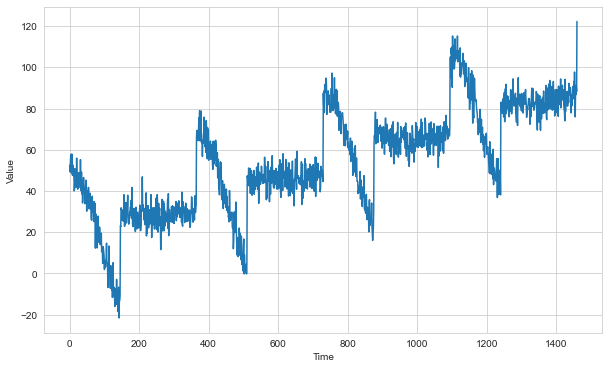

In [5]:
plt.figure(figsize=(10,6))
plot_series(time,series)
plt.show()

In [6]:
def window_dataset(series,window_size,batch_size=32,shuffle_buffer=100):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1,shift=1,drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window:(window[:-1],window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30

In [8]:
split_time = 1000
time_train = time[:split_time]
X_train = series[:split_time]
time_valid = time[split_time:]
X_valid = series[split_time:]

In [9]:
train_set = window_dataset(X_train,window_size,batch_size=128)

In [10]:
train_set

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>

In [11]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences= True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200)
])

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 100)         10200     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
Total params: 30,401
Trainable params: 30,401
Non-trainable params: 0
_________________________________________________________________


In [13]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/20))

In [14]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [15]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 4s 49ms/step - loss: 50.4687 - mae: 50.9682
Epoch 2/100
8/8 [==============================] - 0s 36ms/step - loss: 24.1111 - mae: 24.6044
Epoch 3/100
8/8 [==============================] - 0s 40ms/step - loss: 17.5528 - mae: 18.0416
Epoch 4/100
8/8 [==============================] - 0s 39ms/step - loss: 16.4933 - mae: 16.9837
Epoch 5/100
8/8 [==============================] - 0s 40ms/step - loss: 14.8602 - mae: 15.3485
Epoch 6/100
8/8 [==============================] - 0s 37ms/step - loss: 14.5540 - mae: 15.0442
Epoch 7/100
8/8 [==============================] - 0s 35ms/step - loss: 14.4598 - mae: 14.9482: 0s - loss: 21.1091 - mae: 21.5
Epoch 8/100
8/8 [==============================] - 0s 39ms/step - loss: 14.0635 - mae: 14.5502
Epoch 9/100
8/8 [==============================] - 0s 32ms/step - loss: 13.8157 - mae: 14.3013
Epoch 10/100
8/8 [==============================] - 0s 43ms/step - loss: 13.6736 - mae: 14.1613
Epoch 11/100
8/8 

8/8 [==============================] - 0s 33ms/step - loss: 1992.4373 - mae: 1992.9373
Epoch 86/100
8/8 [==============================] - 0s 35ms/step - loss: 7101.0000 - mae: 7101.5000
Epoch 87/100
8/8 [==============================] - 0s 32ms/step - loss: 4029.2727 - mae: 4029.7727
Epoch 88/100
8/8 [==============================] - 0s 37ms/step - loss: 4938.7524 - mae: 4939.2524
Epoch 89/100
8/8 [==============================] - 0s 38ms/step - loss: 5876.4482 - mae: 5876.9482
Epoch 90/100
8/8 [==============================] - 0s 38ms/step - loss: 6163.3354 - mae: 6163.8354
Epoch 91/100
8/8 [==============================] - 0s 46ms/step - loss: 10032.2715 - mae: 10032.7705
Epoch 92/100
8/8 [==============================] - 0s 39ms/step - loss: 13319.2812 - mae: 13319.7812
Epoch 93/100
8/8 [==============================] - 0s 43ms/step - loss: 14729.5293 - mae: 14730.0293
Epoch 94/100
8/8 [==============================] - 0s 37ms/step - loss: 17577.8359 - mae: 17578.3340
Epoch

(1e-07, 0.0001, 0.0, 30.0)

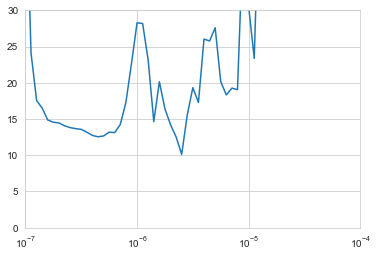

In [16]:
plt.semilogx(history.history['lr'],history.history['loss'])
plt.axis([1e-7,1e-4,0,30])

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)
window_size = 30
train_set = window_dataset(X_train,window_size,batch_size=128)
valid_set = window_dataset(X_valid,window_size,batch_size=128)

In [23]:
model = keras.models.Sequential([
    keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1),input_shape=[None]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.SimpleRNN(100),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x * 200.0)
])

In [24]:
optimizer = keras.optimizers.SGD(learning_rate=1.5e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [25]:
early_stopping = keras.callbacks.EarlyStopping(patience=5)
model_checkpoint = keras.callbacks.ModelCheckpoint("my_checkpoint.h5",
                                                  save_best_only=True)

In [26]:
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping,model_checkpoint])

Epoch 1/500
8/8 [==============================] - 1s 84ms/step - loss: 39.6706 - mae: 40.1673 - val_loss: 44.3144 - val_mae: 44.8144
Epoch 2/500
8/8 [==============================] - 0s 53ms/step - loss: 34.5819 - mae: 35.0802 - val_loss: 15.6592 - val_mae: 16.1543
Epoch 3/500
8/8 [==============================] - 0s 52ms/step - loss: 39.0823 - mae: 39.5805 - val_loss: 13.5597 - val_mae: 14.0526
Epoch 4/500
8/8 [==============================] - 0s 53ms/step - loss: 35.7975 - mae: 36.2957 - val_loss: 9.7921 - val_mae: 10.2840
Epoch 5/500
8/8 [==============================] - 0s 51ms/step - loss: 20.3546 - mae: 20.8502 - val_loss: 8.2518 - val_mae: 8.7407
Epoch 6/500
8/8 [==============================] - 0s 56ms/step - loss: 14.2896 - mae: 14.7781 - val_loss: 12.5651 - val_mae: 13.0592
Epoch 7/500
8/8 [==============================] - 0s 52ms/step - loss: 15.2398 - mae: 15.7305 - val_loss: 6.8811 - val_mae: 7.3649
Epoch 8/500
8/8 [==============================] - 0s 58ms/step - l

In [27]:
model = keras.models.load_model("my_checkpoint.h5")

In [28]:
def model_forcast(model,series,window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w:w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [29]:
rnn_forecast = model_forcast(model,series[split_time-window_size:-1],window_size)[:,0]

7.4635453

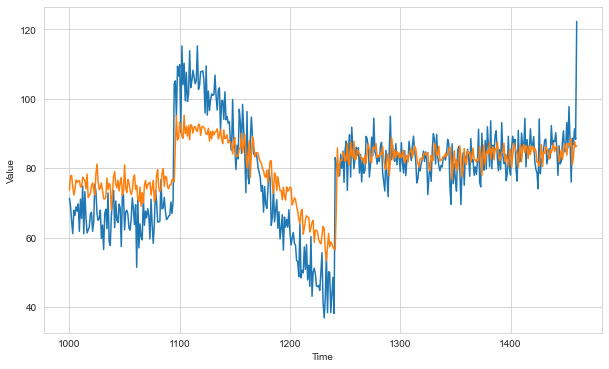

In [30]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)
print('\n')
keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy()

# Sequence_to_Sequence

In [33]:
def seq2_seq_window_dataset(series,window_size,batch_size=32,shuffle_buffer=1000):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=1,drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size+1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1],w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [34]:
for X_batch,Y_batch in seq2_seq_window_dataset(tf.range(10),3,batch_size=1):
    print("X : ",X_batch.numpy())
    print("Y : ",Y_batch.numpy())

X :  [[[1]
  [2]
  [3]]]
Y :  [[[2]
  [3]
  [4]]]
X :  [[[2]
  [3]
  [4]]]
Y :  [[[3]
  [4]
  [5]]]
X :  [[[4]
  [5]
  [6]]]
Y :  [[[5]
  [6]
  [7]]]
X :  [[[3]
  [4]
  [5]]]
Y :  [[[4]
  [5]
  [6]]]
X :  [[[5]
  [6]
  [7]]]
Y :  [[[6]
  [7]
  [8]]]
X :  [[[6]
  [7]
  [8]]]
Y :  [[[7]
  [8]
  [9]]]
X :  [[[0]
  [1]
  [2]]]
Y :  [[[1]
  [2]
  [3]]]


In [35]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [36]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)

In [38]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [39]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-7*10**(epoch/30))

In [40]:
optimizer = keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [41]:
history = model.fit(train_set,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 50ms/step - loss: 52.3347 - mae: 52.8343
Epoch 2/100
8/8 [==============================] - 0s 47ms/step - loss: 25.4676 - mae: 25.9634
Epoch 3/100
8/8 [==============================] - 0s 42ms/step - loss: 23.4963 - mae: 23.9905
Epoch 4/100
8/8 [==============================] - 0s 47ms/step - loss: 21.1478 - mae: 21.6406
Epoch 5/100
8/8 [==============================] - 0s 48ms/step - loss: 19.4398 - mae: 19.9310
Epoch 6/100
8/8 [==============================] - 0s 48ms/step - loss: 18.6537 - mae: 19.1440
Epoch 7/100
8/8 [==============================] - 0s 44ms/step - loss: 18.1677 - mae: 18.6564
Epoch 8/100
8/8 [==============================] - 0s 43ms/step - loss: 17.7659 - mae: 18.2550
Epoch 9/100
8/8 [==============================] - 0s 37ms/step - loss: 17.4325 - mae: 17.9217
Epoch 10/100
8/8 [==============================] - 0s 48ms/step - loss: 17.0944 - mae: 17.5830
Epoch 11/100
8/8 [==============================]

8/8 [==============================] - 0s 46ms/step - loss: 47.5519 - mae: 48.0512
Epoch 87/100
8/8 [==============================] - 0s 38ms/step - loss: 52.7520 - mae: 53.2518
Epoch 88/100
8/8 [==============================] - 0s 45ms/step - loss: 48.5593 - mae: 49.0583
Epoch 89/100
8/8 [==============================] - 0s 43ms/step - loss: 58.7793 - mae: 59.2787
Epoch 90/100
8/8 [==============================] - 0s 43ms/step - loss: 47.9762 - mae: 48.4744
Epoch 91/100
8/8 [==============================] - 0s 40ms/step - loss: 74.7503 - mae: 75.2489
Epoch 92/100
8/8 [==============================] - 0s 41ms/step - loss: 91.8326 - mae: 92.3318
Epoch 93/100
8/8 [==============================] - 0s 46ms/step - loss: 84.3054 - mae: 84.8049
Epoch 94/100
8/8 [==============================] - 0s 37ms/step - loss: 81.9918 - mae: 82.4915
Epoch 95/100
8/8 [==============================] - 0s 35ms/step - loss: 89.2351 - mae: 89.7348
Epoch 96/100
8/8 [==============================] - 0

(1e-07, 0.0001, 0.0, 30.0)

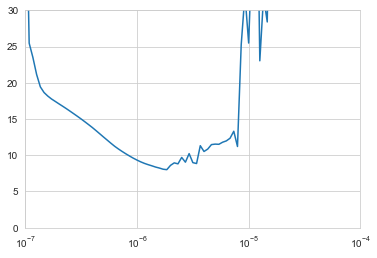

In [42]:
plt.semilogx(history.history['lr'],history.history["loss"])
plt.axis([1e-7,1e-4,0,30])

In [43]:
# Second

In [44]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [45]:
window_size = 30
train_set = seq2_seq_window_dataset(X_train,window_size,batch_size=128)
valid_set = seq2_seq_window_dataset(X_valid,window_size,batch_size=128)

In [46]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,input_shape=[None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x:x*200)
])

In [47]:
optimizer = keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [48]:
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set,epochs=500,
         validation_data=valid_set,
         callbacks=[early_stopping])

Epoch 1/500
8/8 [==============================] - 1s 85ms/step - loss: 54.0972 - mae: 54.5957 - val_loss: 17.9299 - val_mae: 18.4248
Epoch 2/500
8/8 [==============================] - 0s 57ms/step - loss: 34.1508 - mae: 34.6481 - val_loss: 20.4059 - val_mae: 20.9018
Epoch 3/500
8/8 [==============================] - 0s 54ms/step - loss: 27.5301 - mae: 28.0254 - val_loss: 37.8354 - val_mae: 38.3348
Epoch 4/500
8/8 [==============================] - 0s 52ms/step - loss: 21.0690 - mae: 21.5622 - val_loss: 25.2695 - val_mae: 25.7684
Epoch 5/500
8/8 [==============================] - 0s 51ms/step - loss: 17.1614 - mae: 17.6512 - val_loss: 15.4106 - val_mae: 15.9057
Epoch 6/500
8/8 [==============================] - 0s 52ms/step - loss: 15.0371 - mae: 15.5237 - val_loss: 9.4690 - val_mae: 9.9552
Epoch 7/500
8/8 [==============================] - 0s 55ms/step - loss: 13.9664 - mae: 14.4528 - val_loss: 9.0669 - val_mae: 9.5526
Epoch 8/500
8/8 [==============================] - 1s 60ms/step - 

8/8 [==============================] - 0s 43ms/step - loss: 6.3005 - mae: 6.7791 - val_loss: 5.4730 - val_mae: 5.9492
Epoch 64/500
8/8 [==============================] - 0s 47ms/step - loss: 6.2775 - mae: 6.7569 - val_loss: 5.6147 - val_mae: 6.0921
Epoch 65/500
8/8 [==============================] - 0s 46ms/step - loss: 6.2574 - mae: 6.7360 - val_loss: 5.5371 - val_mae: 6.0129
Epoch 66/500
8/8 [==============================] - 0s 45ms/step - loss: 6.2378 - mae: 6.7168 - val_loss: 5.5073 - val_mae: 5.9833
Epoch 67/500
8/8 [==============================] - 0s 48ms/step - loss: 6.2182 - mae: 6.6969 - val_loss: 5.5372 - val_mae: 6.0132
Epoch 68/500
8/8 [==============================] - 0s 51ms/step - loss: 6.1985 - mae: 6.6776 - val_loss: 5.4835 - val_mae: 5.9596
Epoch 69/500
8/8 [==============================] - 0s 45ms/step - loss: 6.1801 - mae: 6.6595 - val_loss: 5.5677 - val_mae: 6.0455
Epoch 70/500
8/8 [==============================] - 0s 44ms/step - loss: 6.1655 - mae: 6.6441 - 

In [49]:
rnn_forecast = model_forcast(model,series[...,np.newaxis],window_size)

In [50]:
rnn_forecast = rnn_forecast[split_time-window_size:-1,-1,0]

5.4435697




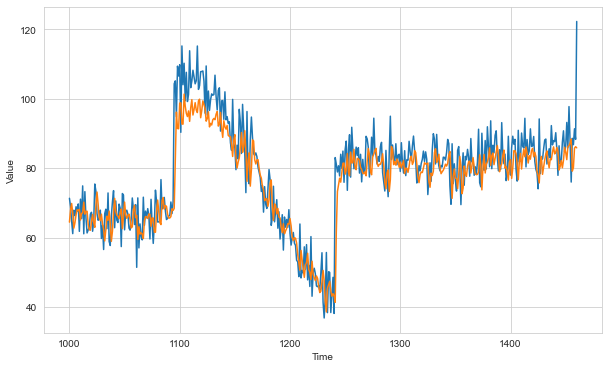

In [52]:
print(keras.metrics.mean_absolute_error(X_valid,rnn_forecast).numpy())
print('\n')
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)


# StateFull RNN

In [93]:
def sequential_window_dataset(series,window_size):
    series = tf.expand_dims(series,axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size+1,shift=window_size,drop_remainder=True)
    ds = ds.flat_map(lambda window:window.batch(window_size+1))
    ds = ds.map(lambda window:(window[:-1],window[1:]))
    return ds.batch(1).prefetch(1)

In [94]:
for X_batch,Y_batch in sequential_window_dataset(tf.range(10),3):
    print(X_batch.numpy(),Y_batch.numpy())

[[[0]
  [1]
  [2]]] [[[1]
  [2]
  [3]]]
[[[3]
  [4]
  [5]]] [[[4]
  [5]
  [6]]]
[[[6]
  [7]
  [8]]] [[[7]
  [8]
  [9]]]


In [95]:
class RestStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self,epoch,logs):
        self.model.reset_states()

In [96]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [97]:
window_size = 30
train_set = sequential_window_dataset(X_train,window_size)

In [98]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True,batch_input_shape=[1,None,1]),
    keras.layers.SimpleRNN(100,return_sequences=True,stateful=True),
    keras.layers.Dense(1),
    keras.layers.Lambda(lambda x: x*200.0)
])

In [99]:
lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8*10**(epoch/30))

In [100]:
reset_states = RestStatesCallback()

In [101]:
optimizer = keras.optimizers.SGD(learning_rate=1e-8,momentum=0.9)
model.compile(loss=keras.losses.Huber(),
             optimizer=optimizer,
             metrics=['mae'])

In [102]:
history = model.fit(train_set,epochs=100,
                   callbacks=[lr_schedule,reset_states])

Epoch 1/100
33/33 [==============================] - 2s 29ms/step - loss: 105.9469 - mae: 106.4470
Epoch 2/100
33/33 [==============================] - 1s 27ms/step - loss: 70.8574 - mae: 71.3573
Epoch 3/100
33/33 [==============================] - 1s 26ms/step - loss: 39.8041 - mae: 40.3010
Epoch 4/100
33/33 [==============================] - 1s 28ms/step - loss: 27.3354 - mae: 27.8303
Epoch 5/100
33/33 [==============================] - 1s 28ms/step - loss: 24.5037 - mae: 24.9973
Epoch 6/100
33/33 [==============================] - 1s 28ms/step - loss: 23.2621 - mae: 23.7538
Epoch 7/100
33/33 [==============================] - 1s 27ms/step - loss: 22.0615 - mae: 22.5543
Epoch 8/100
33/33 [==============================] - 1s 27ms/step - loss: 20.8608 - mae: 21.3528
Epoch 9/100
33/33 [==============================] - 1s 29ms/step - loss: 19.8367 - mae: 20.3302
Epoch 10/100
33/33 [==============================] - 1s 29ms/step - loss: 18.9394 - mae: 19.4315
Epoch 11/100
33/33 [=======

33/33 [==============================] - 1s 32ms/step - loss: 26.7644 - mae: 27.2625
Epoch 85/100
33/33 [==============================] - 1s 25ms/step - loss: 21.9937 - mae: 22.4885
Epoch 86/100
33/33 [==============================] - 1s 26ms/step - loss: 22.2304 - mae: 22.7254
Epoch 87/100
33/33 [==============================] - 1s 28ms/step - loss: 23.3279 - mae: 23.8242
Epoch 88/100
33/33 [==============================] - 1s 31ms/step - loss: 34.7154 - mae: 35.2126
Epoch 89/100
33/33 [==============================] - 1s 33ms/step - loss: 34.6900 - mae: 35.1896
Epoch 90/100
33/33 [==============================] - 1s 34ms/step - loss: 27.3443 - mae: 27.8416
Epoch 91/100
33/33 [==============================] - 1s 35ms/step - loss: 38.9562 - mae: 39.4545
Epoch 92/100
33/33 [==============================] - 1s 34ms/step - loss: 39.0356 - mae: 39.5338
Epoch 93/100
33/33 [==============================] - 1s 34ms/step - loss: 44.8886 - mae: 45.3870
Epoch 94/100
33/33 [=============

In [103]:
#model = keras.models.load_model("my_checkpoint.h5")
#model.reset_states()

In [104]:
model.reset_states()
rnn_forecast = model.predict(series[np.newaxis, : ,np.newaxis])
rnn_forecast = rnn_forecast[0, split_time -1 :-1, 0]

In [105]:
rnn_forecast.shape

(461,)

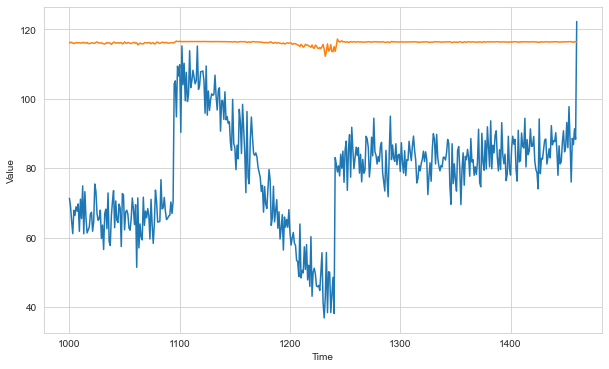

In [106]:
plt.figure(figsize=(10,6))
plot_series(time_valid,X_valid)
plot_series(time_valid,rnn_forecast)